> #### <b style="color: #58a491">파인튜닝</b>
> Pretrained 가중치 초기값 세팅
> - 학습률 스케줄: 높은 학습률로 시작해서 점점 낮춰감
> - 차등 학습률: 레이어별로 학습률을 달리하나?

In [1]:
!pip install keras-adamw

In [2]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# from keras_adamw import AdamW # 안된다
from tools.dataset.five_flowers import IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, CLASS_NAMES, get_datasets

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-01-24 11:05:52.520840: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-24 11:05:52.520860: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-24 11:05:52.520866: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-24 11:05:52.520908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 11:05:52.520923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
strategy.num_replicas_in_sync

1

In [5]:
batch_size = 32
epochs = 13

lr_start = 1e-5
lr_max = 1e-4 * strategy.num_replicas_in_sync
lr_min = 1e-5
lr_rampup_epochs = 3
lr_sustain_epochs = 0
lr_exp_decay = .8

In [6]:
def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        
    return lr

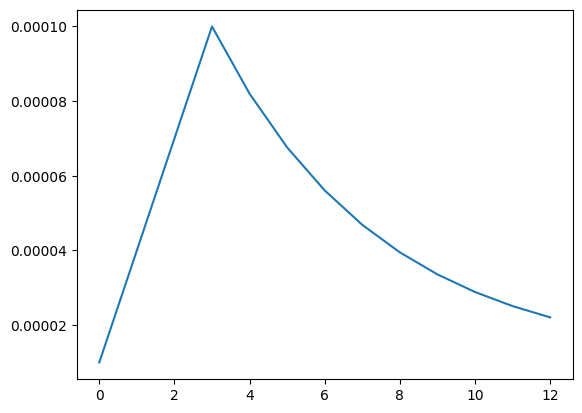

In [7]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
rng = [i for i in range(epochs)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
plt.show()

> #### <b style="color: #a8a4f1">Model</b>

In [47]:
with strategy.scope():
    pretrained_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False ,
        input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]
    )
    
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(
            lambda data:   tf.keras.applications.mobilenet.preprocess_input(
                tf.cast(data, tf.float32)
            ),
            input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS],
        ),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(16, activation='relu', name='flower_dense'),
        tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax', name='flower_prob')
    ])
    
    mult = .4 # for pretrained layers ?? 뭔데 시발
    mult_by_layer = {
        'flower_prob': 1.0,
        'flower_dense': 1.0,
        # pretrained layers
        'block_1_'  : mult * .02,
        'block_2_'  : mult * .04,
        'block_3_'  : mult * .06,
        'block_4_'  : mult * .08,
        'block_5_'  : mult * .1,
        'block_6_'  : mult * .15,
        'block_7_'  : mult * .2,
        'block_8_'  : mult * .25,
        'block_9_'  : mult * .3,
        'block_10_' : mult * .35,
        'block_11_' : mult * .4,
        'block_12_' : mult * .5,
        'block_13_' : mult * .6,
        'block_14_' : mult * .7,
        'block_15_' : mult * .8,
        'block_16_' : mult * .9,
    }
    
    # optimizer = AdamW(lr=LR_MAX, model=model, lr_multipliers=mult_by_layer) # 안돼 시발
    # optimizer = tf.keras.optimizers.AdamW(lr=lr_max, clipnorm=1.0)
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=lr_max),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flower_dense (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2278565 (8.69 MB)
Trainable params: 2244

In [38]:
train_dataset, eval_dataset = get_datasets(batch_size=batch_size)

In [39]:
# train_dataset.as_numpy_iterator().next()[0].shape
train_count, eval_count = 0, 0

for _, l in train_dataset.as_numpy_iterator():
    train_count += l.shape[0]
for _, l in eval_dataset.as_numpy_iterator():
    eval_count += l.shape[0]
    
print(f'train_dataset size: {train_count}, eval_dataset size: {eval_count}')

train_dataset size: 1922, eval_dataset size: 824


In [40]:
steps_per_execution = train_count // batch_size
validation_steps = eval_count // batch_size

In [48]:
history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=epochs,
    callbacks=[lr_callback],
    steps_per_epoch=steps_per_execution,
    validation_steps=validation_steps
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13


2024-01-24 11:45:19.113537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-24 11:45:19.117856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-24 11:45:22.659284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 1.7281 - sparse_categorical_accuracy: 0.2740

2024-01-24 11:45:55.776856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-24 11:45:55.780636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-24 11:45:56.279503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 41s 682ms/step - loss: 1.7281 - sparse_categorical_accuracy: 0.2740 - val_loss: 1.8173 - val_sparse_categorical_accuracy: 0.1713 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/13


2024-01-24 11:46:01.419066: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1502027897907494197
2024-01-24 11:46:01.419081: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9062947510188392717
2024-01-24 11:46:01.419086: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9231809686256091915
2024-01-24 11:46:01.419091: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13749625989768578163
2024-01-24 11:46:01.419095: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12270077632824967879
2024-01-24 11:46:01.419099: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11273776454563792567
2024-01-24 11:46:01.419102: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv 

60/60 [==============================] - 5s 79ms/step - loss: 1.4082 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.8138 - val_sparse_categorical_accuracy: 0.1663 - lr: 4.0000e-05


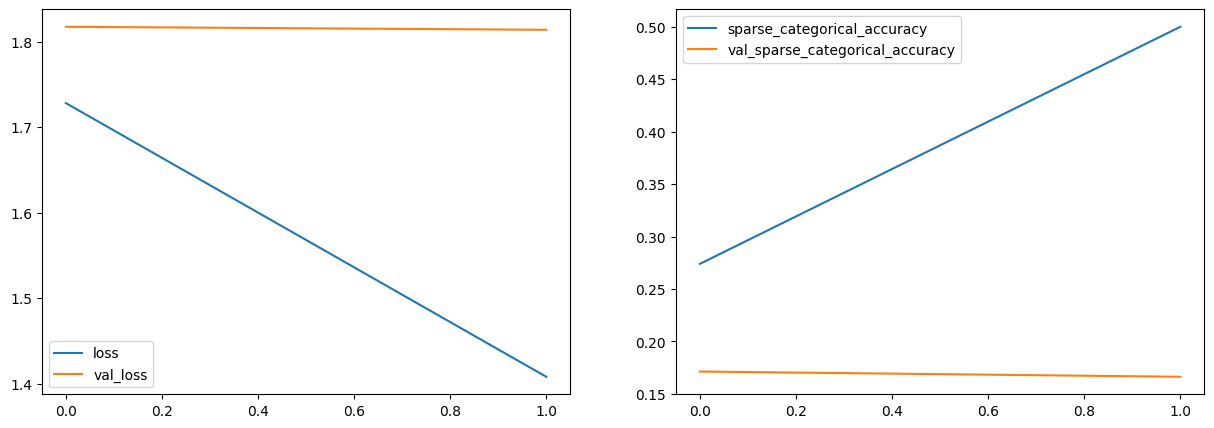

In [50]:
import pandas as pd

df_history = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_history[['loss', 'val_loss']].plot(ax=axes[0])
df_history[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(ax=axes[1])
plt.show()